# Training an intents classification model

Define constants

In [1]:
from os import getcwd, path
import sys
import matplotlib.pyplot as plt
import numpy as np

BASE_PATH = path.dirname(getcwd())
sys.path.append(BASE_PATH)

DATA_UTILS = path.join(BASE_PATH, 'common/data_utils.py')
TRAIN_PATH = path.join(BASE_PATH, 'kc_data.json')
CLASSES_FILE = path.join(BASE_PATH, 'classes.json')

from text_classification.fast_text.train import trainIters

In [2]:
exec(open(DATA_UTILS).read())

Use functions from the utils to extract and preprocess the training data
Refer to `kc_data.json` for the sample data format
`get_data_pairs` is then used to parse data into a tuple of `([list_of_sentences], [list_of_labels])`

In [3]:
X_data, y_data = get_data_pairs(data_from_json(TRAIN_PATH))

classes = list(set(y_data))
num_classes = len(classes)

X_train = X_data
y_train = np.array([
    classes.index(item)
    for item in y_data
], dtype='float32')

Plot the training data

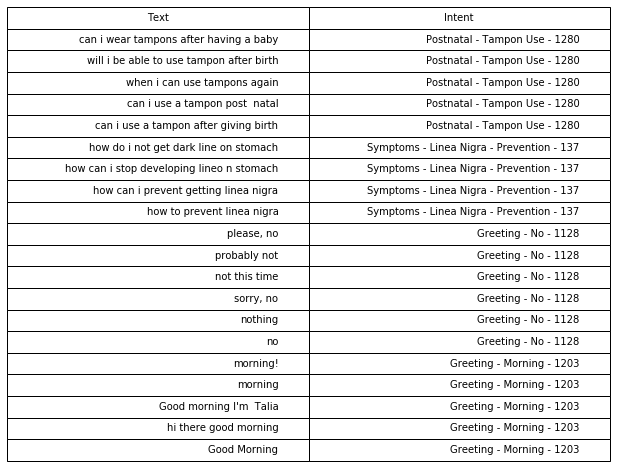

In [4]:
cell_text = [
    [item, y_data[idx] + ' - ' + str(int(y_train[idx]))] 
    for (idx, item) in enumerate(X_train)
]
plt.table(cellText=cell_text[:20],
          colLabels=['Text', 'Intent'],
          loc='center') \
   .scale(1.8,1.8)
plt.axis('off')
plt.show()

In [5]:
print('Number of samples: %s, classes: %s' % (len(X_train), num_classes))

Number of samples: 10256, classes: 1427


Save the classes descriptions as json

In [6]:
import json

with open(CLASSES_FILE, 'w') as classes_file:
    json.dump(classes, classes_file)

In [7]:
import torch
torch.__version__

'0.4.0'

Start training the classification model and save

In [8]:
training_data = [(item, y_train[idx]) for idx, item in enumerate(X_train)]

losses, model = trainIters(training_data, 
                           classes, 
                           n_iters=200, 
                           log_every=5, 
                           verbose=1,
                           learning_rate=1e-2,
                           weight_decay=0,
                           batch_size=64)

Training started
Loading and preprocessing dataset
Preprocessing completed. 2m 46s elapsed
0m 35s (- 22m 58s) (5 2%) 1.8396 - accuracy: 0.0877
1m 18s (- 24m 51s) (10 5%) 0.9516 - accuracy: 0.4874
2m 6s (- 26m 2s) (15 7%) 0.6180 - accuracy: 0.7097
2m 54s (- 26m 14s) (20 10%) 0.4323 - accuracy: 0.8016
3m 36s (- 25m 18s) (25 12%) 0.3429 - accuracy: 0.8475
4m 17s (- 24m 16s) (30 15%) 0.2979 - accuracy: 0.8730
4m 52s (- 22m 57s) (35 17%) 0.2880 - accuracy: 0.8835
5m 30s (- 22m 3s) (40 20%) 0.2487 - accuracy: 0.8967
6m 13s (- 21m 25s) (45 22%) 0.2331 - accuracy: 0.9046
6m 48s (- 20m 24s) (50 25%) 0.3638 - accuracy: 0.8867
7m 19s (- 19m 19s) (55 27%) 0.3003 - accuracy: 0.9016
7m 52s (- 18m 22s) (60 30%) 0.2462 - accuracy: 0.9105
8m 26s (- 17m 32s) (65 32%) 0.1939 - accuracy: 0.9182
8m 57s (- 16m 38s) (70 35%) 0.2417 - accuracy: 0.9139
9m 29s (- 15m 49s) (75 37%) 0.1906 - accuracy: 0.9219
Early stopping
Calibrating model
Training completed


Plot the losses graph (this helps choosing number of epochs and learning rate)

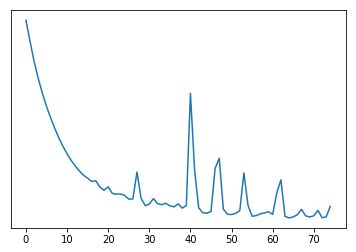

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

losses = [loss for loss in losses if loss < 1.2]

plt.figure()
fig, ax = plt.subplots()
loc = ticker.MultipleLocator(base=5)
ax.yaxis.set_major_locator(loc)
plt.plot(losses)

Test the trained model

In [13]:
from text_classification.fast_text.predict import predict
import torch.nn.functional as F

TEST_SENTENCE = 'can i wear tampons'

with torch.no_grad():
    model.eval()
    scores = model([TEST_SENTENCE])
    print(scores.size())
    topk_scores, topk_idx = torch.topk(scores, 10)
    print(topk_idx[0])
    print(topk_scores[0])
    print(classes[topk_idx[0,0].item()])

torch.Size([1, 1427])
tensor([  544,    82,   460,  1123,  1053,   796,  1269,  1066,  1068,
          963])
tensor([ 89.9768,  76.9950,  71.4591,  68.0115,  67.7423,  64.5813,
         64.4916,  64.3007,  63.1414,  60.9896])
Birth - Caesarean - After - Scars


In [11]:
def to_scalar(var):
    """
    returns a python float
    """
    return var.view(-1).data.tolist()[0]


def argmax(vec):
    """
    returns the argmax as a python int
    """
    _, idx = torch.max(vec, -1)
    return to_scalar(idx)

In [12]:
with torch.no_grad():
    model.eval()
    print(classes[argmax(model(['sorry, no']))])

Greeting - No
